<a href="https://colab.research.google.com/github/PashaIanko/RestrictedBolzmannMachine/blob/main/Omniglot_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Packages, Constants & Functions**

In [55]:
# Preprocessing
CROP_SIZE_ = 90
MEAN_ = 0.5
STD_ = 0.5
IMG_SIZE_ = CROP_SIZE_

# Train
EPOCHS_ = 150
BATCH_SIZE_ = 80
LABEL_FROM_ = 0
LABEL_TO_ = 400
LABEL_MIN_ = 0
LABEL_MAX_ = 963

# Alphabets
# key - alphabet, value - start and finish labels
ALPHABETS_DICT_ = {
    'First': [0, 25]  # Label limits
}

In [34]:
%%capture

url_dbn = 'https://raw.githubusercontent.com/PashaIanko/RestrictedBolzmannMachine/main/DBN.py'
url_rbm = 'https://raw.githubusercontent.com/PashaIanko/RestrictedBolzmannMachine/main/RBM.py'

utils = {
    'DBN.py': url_dbn,
    'RBM.py': url_rbm
}

for file, url in utils.items():
    !wget -O {file} {url} {file}

In [35]:
import torch
import torchvision as tv
from torchvision import datasets

# Models
from DBN import DBN

# Plotting
import matplotlib.pyplot as plt

# Download
from google.colab import drive
from os import path

# Utils
import numpy as np
import random
import math

In [36]:
def fix_seeds():
    torch.manual_seed(0)
    random.seed(0)
    np.random.seed(0)

In [37]:
def visualize_symbols(dataset, n_subplots, image_shape):
    n_rows_cols = int(math.sqrt(n_subplots))
    fig, axes = plt.subplots(
        n_rows_cols, 
        n_rows_cols, 
        sharex = True,
        sharey = True,
        figsize = (10, 10)
    )
    for i in range(n_subplots):
        row = i % n_rows_cols
        col = i // n_rows_cols
        img, _ = dataset[i] 
        axes[row, col].imshow(torch.flatten(img).reshape(image_shape), cmap='binary')

In [38]:
def find_image(ds, label):
    for item in ds:
        if item[1] == label:
            return item[0]

def visualize_letters(labels, image_shape, ds):
    n_subplots = len(labels)
    
    n_rows_cols = int(math.sqrt(n_subplots))
    fig, axes = plt.subplots(
        n_rows_cols, 
        n_rows_cols, 
        sharex = True,
        sharey = True,
        figsize = (10, 10)
    )

    for i in range(n_subplots):
        row = i % n_rows_cols
        col = i // n_rows_cols
        label = labels[i]
        
        image = find_image(ds, label)
        axes[row, col].imshow(torch.flatten(image).reshape(image_shape), cmap='binary')

def prepare_data(ds, label_from, label_to):
    labels = []
    images = []
    for item in ds:
        if label_from <= item[1] <= label_to:
            labels.append(item[1])
            images.append(item[0])
    return images, labels

In [39]:
def move_parameters_to_cpu(dbn_mnist):
    for layer in dbn_mnist.rbm_layers:
        layer.W = layer.W.cpu()
        layer.h_bias = layer.h_bias.cpu()
        layer.v_bias = layer.v_bias.cpu()

def apply_threshold(weights, threshold=0):
    return weights * (abs(weights) > threshold)
  
def plot_layer_receptive_fields(weights, num_subplots=100):
    n_rows_cols = int(math.sqrt(num_subplots))
    fig, axes = plt.subplots(n_rows_cols, n_rows_cols, sharex=True, sharey=True, figsize=(20, 20))
    for i in range(num_subplots):
        row = i % n_rows_cols
        col = i // n_rows_cols
        axes[row, col].imshow(weights[i,:].reshape((IMG_SIZE_,IMG_SIZE_)), cmap=plt.cm.gray) 

## **Data Download**

- For neural networks, we need to scale data before learning
- Need to obtain tensor shape
- Fix seeds for reproducibility

In [40]:
%%capture 

fix_seeds()

transformer = tv.transforms.Compose(
    [
        tv.transforms.CenterCrop(CROP_SIZE_),
        tv.transforms.ToTensor(),
        
        # Transform to {-1, 1} binary image
        tv.transforms.Normalize(mean=(MEAN_,), std=(STD_),)  
    ]
)

train = datasets.Omniglot(
    root = '/content/',
    download = True,
    background = True,
    transform = transformer
)

test = datasets.Omniglot(
    root = '/content/',
    download = True,
    background = False,
    transform = transformer
)

# import tensorflow_datasets as tfds 

# %%capture
# train = tfds.load("omniglot", 
#                   split = 'train', 
#                   as_supervised = False, 
#                   shuffle_files = False)
# %%capture
# test = tfds.load("omniglot",
#                  split = 'test',
#                  as_supervised = False,
#                  shuffle_files = False)

Image shape = torch.Size([1, 90, 90])


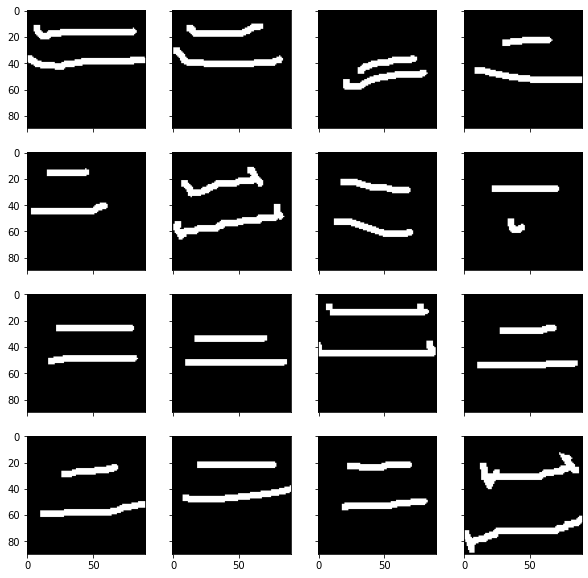

In [41]:
img, _ = train[0]
print(f'Image shape = {img.shape}')
visualize_symbols(train, 16, image_shape = (CROP_SIZE_, CROP_SIZE_))

In [ ]:
# __getitem__ structure - tensor (image) + label (one label for 20 images of single letter)
train.__getitem__(19)

(tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]), 0)

## **Visualize Data (alphabets)**

- 1st conclusion:  
    - 1 Dataset
    - 50 Alphabets
    - 20-30 characters in each (varies)
    - 20 images for one character
    - First 20 images (from 0 to 19) are labeled '0' (first character),
        then next character is labeled '1' and so on
    - 964 unique labels


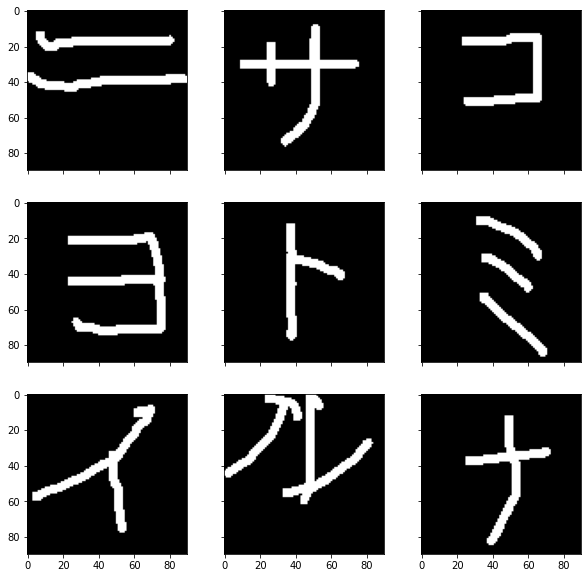

In [48]:
# Visualize first few letters of one alphabet
visualize_letters(
    labels = [0, 1, 2,
              3, 4, 5,
              6, 7, 8
              ],
    
    image_shape = (IMG_SIZE_, IMG_SIZE_),
    ds = train
)

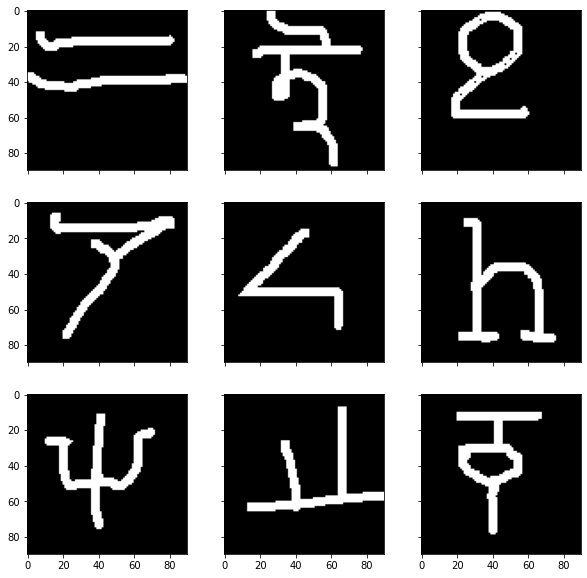

In [49]:
# Visualize letters of different alphabets 
visualize_letters(
    labels = [
              0, 30, 60,
              90, 120, 150,
              180, 210, 240
              ],
    image_shape = (IMG_SIZE_, IMG_SIZE_),
    ds = train
)

## **Prepare Data (Select alphabets & labels)**

- First alphabet - labels from [0, 25]

In [ ]:
# all_labels = [item[1] for item in train]
# all_images = [item[0] for item in train]

In [50]:
# Slice and choose only subset of certain alphabet labels
images, labels = prepare_data(
    train, 
    label_from = LABEL_FROM_,  
    label_to = LABEL_TO_
)
print(f'Size of the dataset = {len(labels)}')

Size of the dataset = 8020


In [51]:
# To Tensors
labels = torch.FloatTensor(labels)
buffer = torch.Tensor(len(images), IMG_SIZE_, IMG_SIZE_)
torch.cat(images, out=buffer)
images = buffer

In [52]:
print(type(labels), type(images))
print(type(labels[0]), type(images[0]))

<class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'>


## **Deep Belief Network model & fit**

- Deep Belief Network - a stack of Restricted Bolzmann Machines
    - RBM is a bipartite graph with input and hidden layer
    - Hidden layer captures dependencies and features
- Each layer learns more complex and abstract features
- Used as feature extraction method (generative model)
- No output neurons
- Two phases (negative & positive) during learning (reconstruction)




In [56]:
fix_seeds()

model = DBN(
    visible_units = IMG_SIZE_ * IMG_SIZE_,
    hidden_units = [500, 500, 1200],  # [500, 500, 1200],
    k = 1,
    learning_rate = 0.07,
    learning_rate_decay = False,
    initial_momentum = 0.5,
    final_momentum = 0.9,
    weight_decay = 0.00002,
    xavier_init = False,
    increase_to_cd_k = False,
    use_gpu = True
)

In [57]:
fix_seeds()

model.train_static(
    images,
    labels,
    EPOCHS_,
    BATCH_SIZE_
)

move_parameters_to_cpu(model)

--------------------
Training RBM layer 1
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |33.5557   |6.7961   |20502.2188 |2893.4993   |
|20    |33.6325   |6.8127   |20955.3828 |2885.2327   |
|30    |33.7639   |6.8414   |21866.4180 |3106.5483   |
|40    |33.8742   |6.8453   |22884.4727 |3243.8044   |
|50    |34.0070   |6.8505   |23787.6328 |3359.0649   |
|60    |34.0822   |6.8597   |24529.8008 |3421.9988   |
|70    |34.1528   |6.8637   |25194.7930 |3579.5398   |
|80    |29.3456   |6.2994   |1768.9648 |479.4280   |
|90    |29.0986   |6.1240   |2709.3982 |717.0747   |
|100    |29.2614   |6.1847   |2464.7139 |744.2284   |
|110    |27.7628   |5.9283   |2282.6562 |715.7606   |
|120    |27.5788   |5.9101   |2608.9448 |829.9421   |
|130    |27.4467   |5.9896   |3242.7815 |902.1592   |
|140    |27.2353   |5.8385   |3776.2664 |927.2998   |
|150    |28.0076   |6.1012   |4201.5420 |994.0015   |
--------------------
Training RBM layer 2
|Epoch |avg_rec_err |std_rec_err  |mean_gra

## **Linear read-outs. Receptive fields visualization**

In [58]:
num_layers = len(model.rbm_layers)
learned_weights = [
    model.rbm_layers[i].W.numpy() for i in range(num_layers)
]

In [59]:
learned_weights_thresh = [apply_threshold(layer, .08) for layer in learned_weights]

ValueError: ignored

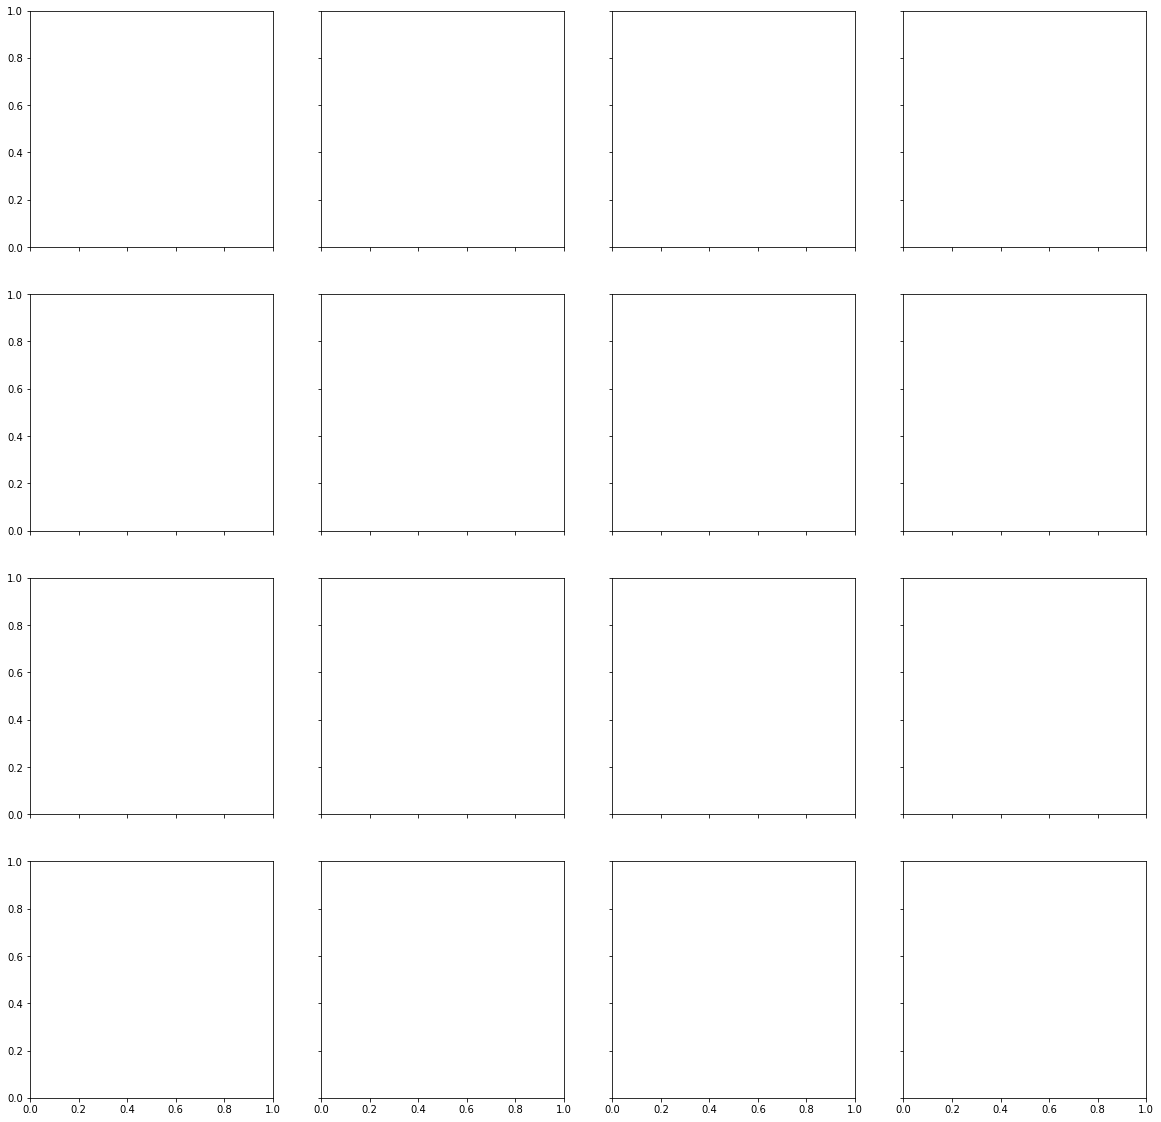

In [ ]:
plot_layer_receptive_fields(learned_weights_thresh[0], num_subplots = 16)

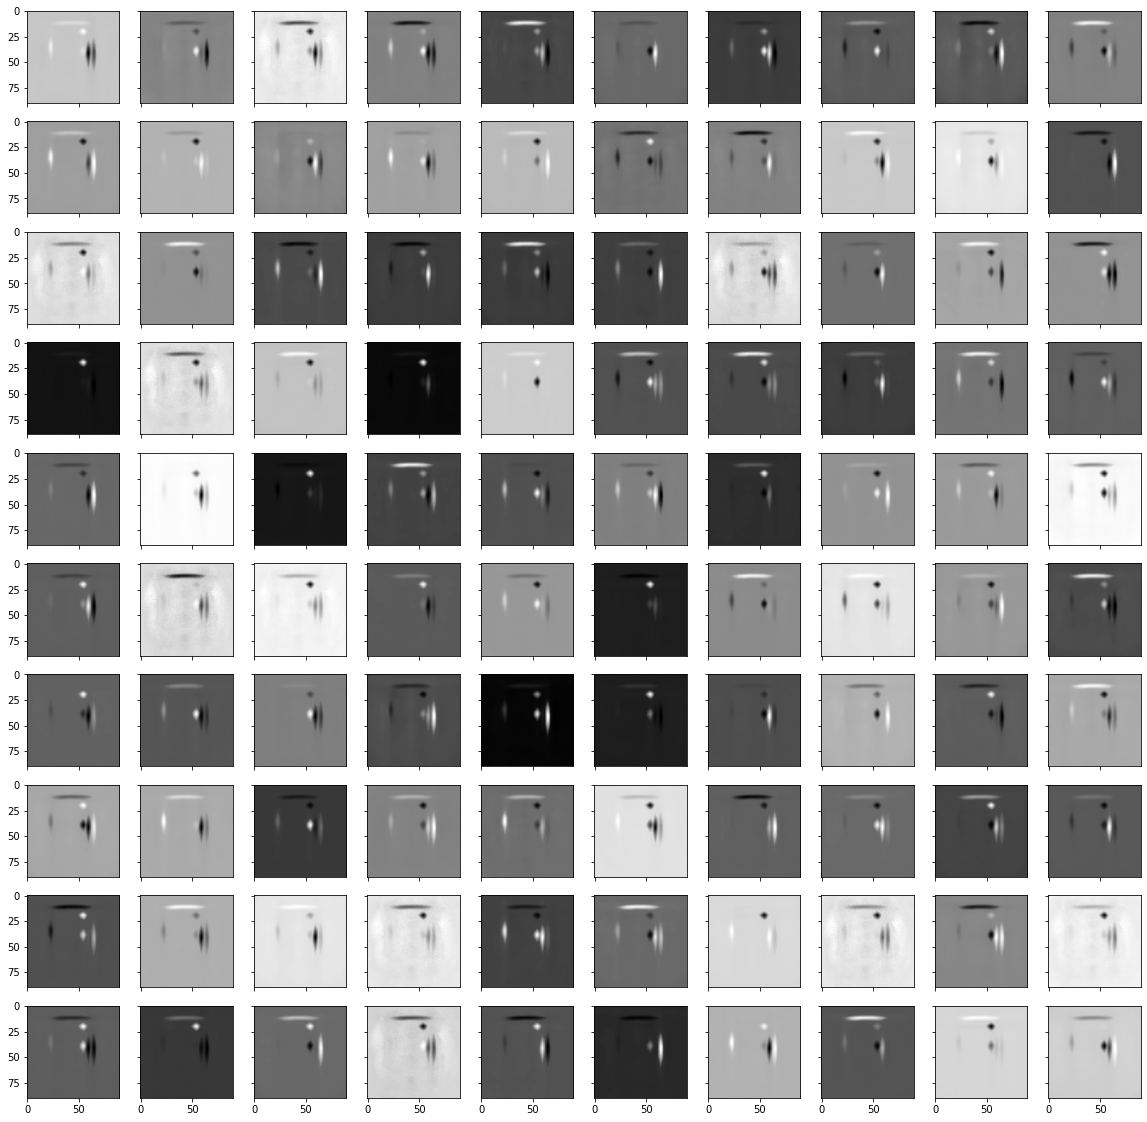

In [60]:
weight_product = (learned_weights[0] @ learned_weights[1]).T
plot_layer_receptive_fields(
    apply_threshold(weight_product), num_subplots = 100
)

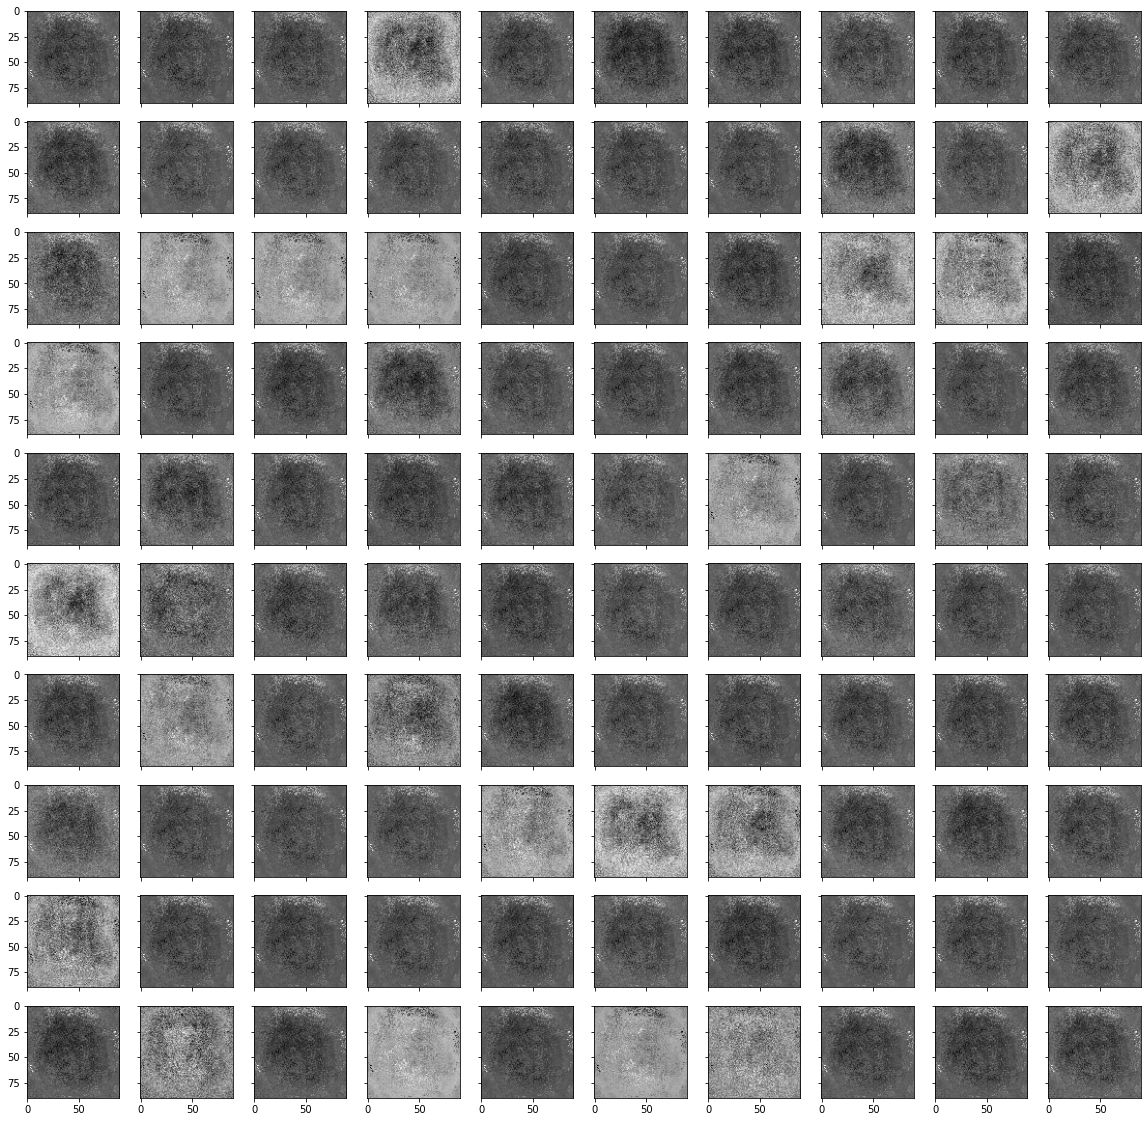

In [ ]:
learned_weights_layer_1 = model.rbm_layers[0].W.numpy()
learned_weights_layer_2 = model.rbm_layers[1].W.numpy()

learned_weights_layer_1 = apply_threshold(learned_weights_layer_1, 0)
learned_weights_layer_2 = apply_threshold(learned_weights_layer_2, 0)

learned_weights_product = (learned_weights_layer_1 @ learned_weights_layer_2).T  # here we do the projection
learned_weights_product = apply_threshold(learned_weights_product, 0)

plot_layer_receptive_fields(learned_weights_product)